# Querying the OpenAlex data for works from Japan

Our questions are:
1. How many sources of scholarly works are in Japan?
2. What are the types of these sources? Journals? Repositories? Conferences?
    - For journals, what are the publishers?
    - For repositories, what are the host organizations?
3. What are the names of these sources?
4. How many works have Japanese sources? How does this vary over time?


In [1]:
import requests

### Question 1: How many sources of scholarly works are in Japan?

Let's start with the first question: How many sources of scholarly works are in Japan?

To do this, we will query the `/sources` API endpoint, and use a **filter** to limit it to sources where the `country_code` is `JP`.

In [2]:
country_code = 'JP'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
}
r = requests.get(url, params=params)
num_sources = r.json()['meta']['count']
print(f"There are {num_sources} sources with country_code 'JP' (Japan)")

There are 2162 sources with country_code 'JP' (Japan)


### Question 2: What are the types of these sources?
The next question is: What are the *types* of these sources. Possible types are listed in the API docs on the [Source object](https://docs.openalex.org/api-entities/venues/venue-object#type): `journal`, `repository`, `conference`, `ebook platform`.

To answer this question, we can add a `group_by` to our API query, grouping by the `type` field and counting the number of sources:

In [7]:
params = {
    'filter': f'country_code:{country_code}',
    'group_by': 'type',
}
r = requests.get(url, params=params)
print("Number of sources in Japan for each *type* of source:")
for item in r.json()['group_by']:
    print(f'  "{item["key"]}": {item["count"]} sources')

Number of sources in Japan for each *type* of source:
  "journal": 2162 sources


All of the Japanese sources are of type: `journal`. We are not seeing any of the other types of sources.

Why is this? TODO

TODO introduce question 3

In [4]:
# page through to get all sources
# use paging technique from `paging.ipynb`
# url with a placeholder for page number
country_code = 'JP'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
    'page': 1,  # initaliaze `page` param to 1
}

has_more_pages = True
fewer_than_10k_results = True

japanese_sources = []

# loop through pages
loop_index = 0
while has_more_pages and fewer_than_10k_results:
    
    page_with_results = requests.get(url, params=params).json()
    
    # loop through partial list of results
    results = page_with_results['results']
    for source in results:
        japanese_sources.append(source)

    # next page
    params['page'] += 1
    
    # end loop when either there are no more results on the requested page 
    # or the next request would exceed 10,000 results
    per_page = page_with_results['meta']['per_page']
    has_more_pages = len(results) == per_page
    fewer_than_10k_results = per_page * params['page'] <= 10000
    loop_index += 1
print(f"collected {len(japanese_sources)} sources (using {loop_index+1} api calls)")

collected 2162 sources (using 88 api calls)


In [5]:
from collections import Counter
c = Counter([source['host_organization'] for source in japanese_sources if source['host_organization']])
print(f"The Japanese sources are associated with {len(c)} different host organizations (publishers).")

The Japanese sources are associated with 181 different host organizations (publishers).


In [6]:
num_works = sum([source['works_count'] for source in japanese_sources])
print(f"There are {num_works} works (articles) with Japanese sources.")

There are 3700657 works (articles) with Japanese sources.


In [14]:
import pandas as pd
data = []
for source in japanese_sources:
    data.append({
        'id': source['id'].split('/')[-1],
        'issn_l': source['issn_l'],
        'display_name': source['display_name'],
        'host_organization': source['host_organization'],
        'works_count': source['works_count'],
        'cited_by_count': source['cited_by_count'],
        'type': source['type'],
    })
df = pd.DataFrame(data)

In [15]:
df

,id,issn_l,display_name,host_organization,works_count,cited_by_count,type
0,S4210210193,0021-4728,Journal of the Japan Society of Mechanical Eng...,https://openalex.org/P4310313571,61499,62161,journal
1,S4210231715,0369-4305,Nippon Hoshasen Gijutsu Gakkai Zasshi,None,49470,52150,journal
2,S119212824,0031-9015,Journal of the Physical Society of Japan,https://openalex.org/P4310313296,44084,692627,journal
3,S2751469422,0047-1852,Nihon rinsho. Japanese journal of clinical med...,None,40379,46497,journal
4,S95305481,0009-2673,Bulletin of the Chemical Society of Japan,https://openalex.org/P4310320565,38084,526331,journal
...,...,...,...,...,...,...,...
2157,S4210228306,2185-7954,Seibutsu to kisho,None,0,1,journal
2158,S4210229600,0368-8887,"Memoirs of the College of Science, University ...",https://openalex.org/P4310315698,0,1,journal
2159,S4210229661,1344-7661,Peptide science,None,0,1,journal
2160,S4210232673,0018-3482,"Journal of the Faculty of Science, Hokkaido Un...",https://openalex.org/P4310313472,0,1,journal


Number of works per year per source.

In [21]:
japanese_sources[0]['counts_by_year']

[{'year': 2023, 'works_count': 25, 'cited_by_count': 14},
 {'year': 2022, 'works_count': 204, 'cited_by_count': 46},
 {'year': 2021, 'works_count': 243, 'cited_by_count': 52},
 {'year': 2020, 'works_count': 244, 'cited_by_count': 26},
 {'year': 2019, 'works_count': 272, 'cited_by_count': 26},
 {'year': 2018, 'works_count': 302, 'cited_by_count': 53},
 {'year': 2017, 'works_count': 286, 'cited_by_count': 56},
 {'year': 2016, 'works_count': 284, 'cited_by_count': 64},
 {'year': 2015, 'works_count': 748, 'cited_by_count': 54},
 {'year': 2014, 'works_count': 767, 'cited_by_count': 69},
 {'year': 2013, 'works_count': 770, 'cited_by_count': 56},
 {'year': 2012, 'works_count': 807, 'cited_by_count': 65}]

In [23]:
data = []
for source in japanese_sources:
    for year_count in source['counts_by_year']:
        data.append({
            'id': source['id'],
            'year': year_count['year'],
            'works_count': year_count['works_count'],
            'cited_by_count': year_count['cited_by_count'],
        })
df_counts_by_year = pd.DataFrame(data)

In [24]:
df_counts_by_year

,id,year,works_count,cited_by_count
0,https://openalex.org/S4210210193,2023,25,14
1,https://openalex.org/S4210210193,2022,204,46
2,https://openalex.org/S4210210193,2021,243,52
3,https://openalex.org/S4210210193,2020,244,26
4,https://openalex.org/S4210210193,2019,272,26
...,...,...,...,...
20598,https://openalex.org/S4210240815,2021,0,9
20599,https://openalex.org/S4210240815,2020,0,4
20600,https://openalex.org/S4210240815,2019,0,11
20601,https://openalex.org/S4210240815,2018,0,2


In [37]:
df_counts_by_year.groupby('year')['works_count'].sum()

year
2012    82235
2013    82640
2014    79368
2015    78816
2016    74602
2017    70666
2018    69315
2019    67898
2020    65098
2021    61152
2022    48793
2023     6154
Name: works_count, dtype: int64

(0.0, 86464.3)

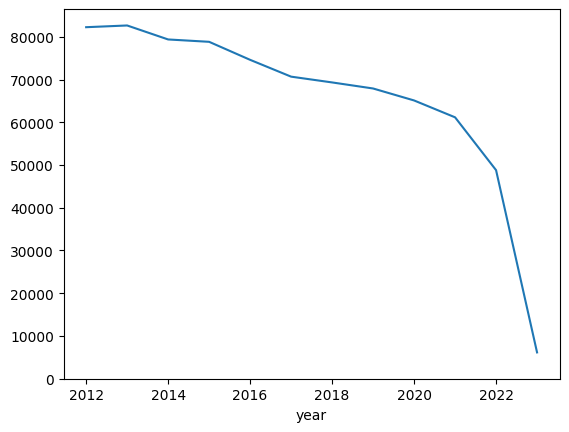

In [54]:
df_counts_by_year.groupby('year')['works_count'].sum().plot().set_ylim(bottom=0)

In [25]:
params = {
    'filter': f'country_code:{country_code}',
    'group_by': 'counts_by_year',
}
r = requests.get(url, params=params)
print(r.json()['group_by'])

KeyError: 'group_by'

Why couldn't we have just done a `group_by` API query?

Because `counts_by_year` is not a valid field to group sources (https://docs.openalex.org/api-entities/venues/group-venues).

But what about querying for `Works` and grouping by `publication_year`?

We cannot filter works by `source.country_code`. Maybe we should add this to the API.

We can, however, filter works by `authorships.institutions.country_code`, so we can answer a different but related question: what are the counts per year of works having authors affiliated with Japanese institutions?

In [28]:
country_code = 'JP'
url = f"https://api.openalex.org/works"
params = {
    'filter': f'authorships.institutions.country_code:{country_code}',
    'group_by': 'publication_year',
}
r = requests.get(url, params=params)

In [30]:
r.json()

{'meta': {'count': 165,
  'db_response_time_ms': 174,
  'page': 1,
  'per_page': 200},
 'results': [],
 'group_by': [{'key': '2021', 'key_display_name': '2021', 'count': 179125},
  {'key': '2020', 'key_display_name': '2020', 'count': 169882},
  {'key': '2019', 'key_display_name': '2019', 'count': 162767},
  {'key': '2018', 'key_display_name': '2018', 'count': 157187},
  {'key': '2017', 'key_display_name': '2017', 'count': 148183},
  {'key': '2022', 'key_display_name': '2022', 'count': 142674},
  {'key': '2015', 'key_display_name': '2015', 'count': 142462},
  {'key': '2016', 'key_display_name': '2016', 'count': 140656},
  {'key': '2014', 'key_display_name': '2014', 'count': 140168},
  {'key': '2013', 'key_display_name': '2013', 'count': 140034},
  {'key': '2012', 'key_display_name': '2012', 'count': 134980},
  {'key': '2011', 'key_display_name': '2011', 'count': 131909},
  {'key': '2010', 'key_display_name': '2010', 'count': 128369},
  {'key': '2009', 'key_display_name': '2009', 'count'

In [38]:
data = []
for item in r.json()['group_by']:
    data.append({
        'year': int(item['key']),
        'works_count': item['count'],
    })
df_affiliations_count = pd.DataFrame(data)

(0.0, 181332.25)

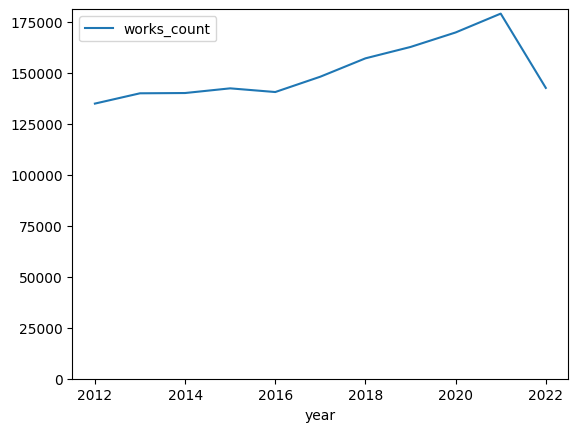

In [50]:
df_affiliations_count.sort_values('year', inplace=True)
# df_affiliations_count[df_affiliations_count['year']>=2012&df_affiliations_count['year']<2023].set_index('year').plot()
df_affiliations_count.loc[(df_affiliations_count['year']>=2012)&(df_affiliations_count['year']<2023)].set_index('year').plot().set_ylim(bottom=0)